<a href="https://colab.research.google.com/github/eunseochu/OB_14th/blob/main/%ED%8C%8C%EC%9D%B4%EC%8D%AC_%EB%94%A5%EB%9F%AC%EB%8B%9D_%ED%85%90%EC%84%9C%ED%94%8C%EB%A1%9C_%EC%9D%B4%EB%AF%B8%EC%A7%80%EB%B6%84%ED%95%A0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **7) 이미지 분할(Segmentation)**

**이미지 분할이란?** <br/>
이미지 분할 또는 세그멘테이션은 이미지를 구성하는 모든 픽셀에 대해 픽셀 단위로 분류하는 것
- 모든 픽셀은 어떤 클래스에 속한다
- 배경 클래스와 객체 클래스로 구성된 이미지가 있다면, 모든 픽셀은 배경 또는 객체 중 하나로 분류
- 모든 픽셀에 대한 정답 클래스를 레이블 처리한 데이터셋을 가지고, 딥러닝 모델을 훈련시키면 <br/> 정답 클래스를 알지 못하는 새로운 이미지에 대해서도 배경과 객체를 분리할 수 있음

**이미지 분할의 종류** <br/>
이미지 분할은 의미 분할과 인스턴스 분할로 구성
- 의미 분할은 같은 범주의 여러 객체를 하나의 범주로 묶어서 구분
- 인스턴스 분할은 같은 범주에 속하더라도 서로 다른 객체를 구분

#### **7-1) 데이터셋 준비**
이미지 분할 예제에 사용할 데이터셋은 Oxford-IIIT Pet Dataset
- 반려동물의 이미지 및 분류 레이블, 각 이미지를 구성하는 픽셀 단위의 마스크로 구성
  - 마스크는 각 픽셀에 대한 범주 레이블을 나타냄
- 각 픽셀은 다음의 세 가지 범주 중 하나에 속함
  - class 1: 반려동물이 속한 픽셀(다음 그림의 노란색 영역)
  - class 2: 반려동물과 인접한 픽셀(빨간색 영역)
  - class 3: 위에 속하지 않는 경우/주변 픽셀(파란색 영역)

**라이브러리 불러오기**

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pylab as plt
import cv2
from tqdm.notebook import tqdm
import tensorflow_datasets as tfds
from google.colab.patches import cv2_imshow

**주요 파라미터 설정**
- 모델 학습에 필요한 입력 이미지의 크기 및 학습 파라미터 설정
- 주요 파라미터를 따로 정리하면 모델의 세부 튜닝 작업을 효율적으로 할 수 있음

In [2]:
# 이미지 크기
img_w = 128
img_h = 128
img_c = 3
img_shape = (img_w,img_h,img_c)

# 모델 학습
epoch_num = 5
learning_rate = 0.0001
buffer_size = 1000
batch_size = 16

**데이터셋 로드** <Br/>
탠서플로 데이터셋에서 옥스포드 반려동물 데이터를 불러옴
- 메타 정보를 가져와 info 변수에 저장

In [3]:
# 텐서플로 데이터셋 로드
ds_str='oxford_iiit_pet'
ds, info = tfds.load(name=ds_str, with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteRPZ74P/oxford_iiit_pet-train.tfrecord*...:…

Generating test examples...:   0%|          | 0/3669 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteRPZ74P/oxford_iiit_pet-test.tfrecord*...: …

Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.


**이미지 전처리 함수** <br/>
원본 이미지와 분할 마스클르 전처리하는 함수를 정의
- 이미지 크기를 사전에 정의한 (!28, 128) 크기로 변경하고 자료형을 변환
- 원본 이미지의 픽셀을 255로 나눠서 0~1 범위로 정규화
- 마스크는 0, 1, 2의 정수형 값을 갖도록 1을 차감

In [4]:
# 이미지 전처리 함수
def preprocess_image(ds):
    # 원본 이미지
    img = tf.image.resize(ds['image'], (img_w, img_h))
    img = tf.cast(img, tf.float32) / 255.0
    # 분할 마스크
    mask = tf.image.resize(ds['segmentation_mask'], (img_w, img_h))
    mask = tf.cast(mask, tf.int32)
    mask = mask - 1
    return img, mask

**데이터 전처리 파이프라인** <br/>
앞에서 정의한 전처리 함수를 훈련 셋, 테스트 셋에 매핑해 주고 미니배치로 분할

In [5]:
# 데이터 전처리 파이프라인
train_ds = ds['train'].map(preprocess_image).shuffle(buffer_size).batch(batch_size).prefetch(2)
test_ds = ds['test'].map(preprocess_image).shuffle(buffer_size).batch(batch_size).prefetch(2)

print(train_ds)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 128, 128, 1), dtype=tf.int32, name=None))>


**샘플 배치 선택** <Br/>

In [6]:
# 샘플 배치 선택
img, mask = next(iter(train_ds))
len(img)

16

- 16개의 샘플 이미지와 마스크 이미지 존재

**샘플 이미지 출력** <Br/>
0~1 사이의 값이므로 255를 곱해서 정규화 이전의 원래 값으로 복원

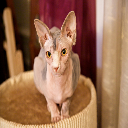

In [7]:
# 샘플 이미지 출력
img = np.array(img[0])*255.0
img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
cv2_imshow(img)

**마스크 이미지 출력** <Br/>
0~2 사이의 값이므로 2로 나눈 다음에 255를 곱하면 RGB 이미지로 표현 가능

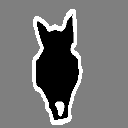

In [8]:
# 샘플 마스크 출력
mask = (np.array(mask[0])/2)*255.0
cv2_imshow(mask)

#### **7-2) U-Net 모델 (인코더-디코더)**
사전 학습된 VGG16 모델을 인코더로 활용하는 U-Net 모델을 생성
- VGG16은 이미지넷 경진 대회를 통해 성능이 검증된 모델
- 사전 학습된 모델 없이 U-Net을 구성하여 학습을 진행해도 학습은 가능
  - 데이터 개수가 충분하고, 시간이 충분하다는 전제 필요
  - 제한된 자원으로 양호한 성능을 내기 위해 사전 학습된 모델을 베이스 모델로 활용하는 전이 학습 방법 사용

**VGG16 모델** <Br/>
VGG16 모델을 최종 레이어를 제외한 채로 불러옴

In [9]:
# VGG16 모델
base_model = tf.keras.applications.VGG16(input_shape=img_shape, include_top=False)

58889256/58889256 [==============================] - 4s 0us/step


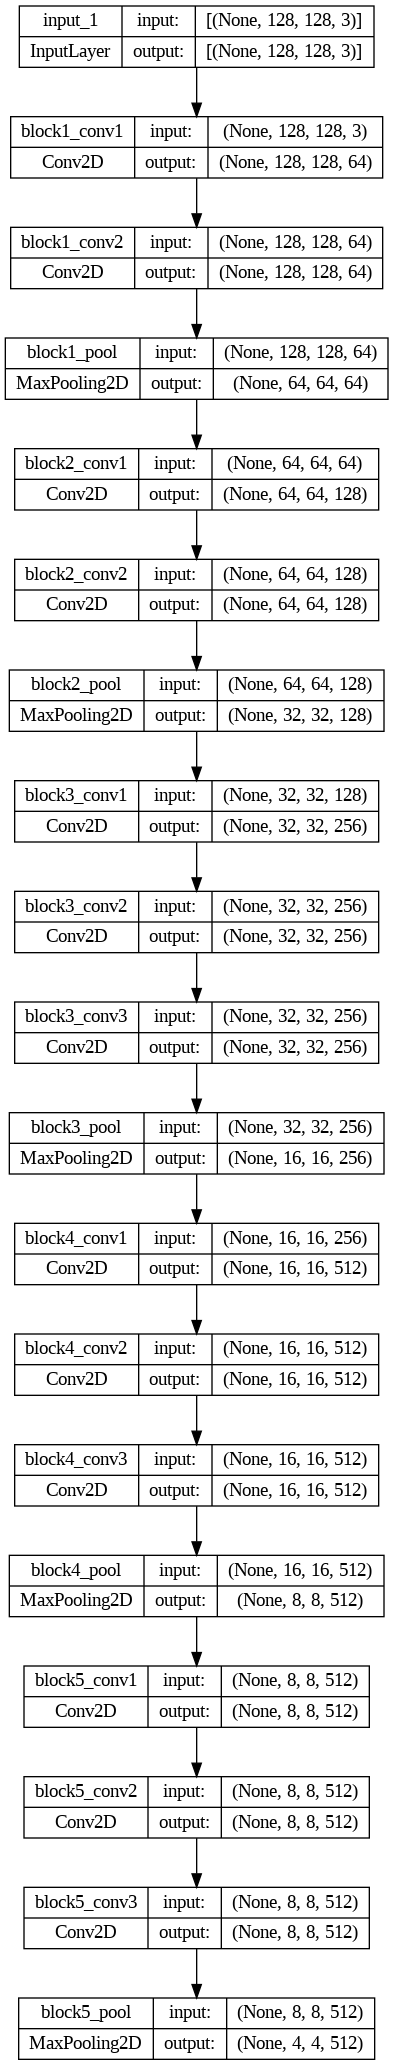

In [10]:
# 모델 구조
tf.keras.utils.plot_model(base_model,show_shapes=True)

- 합성곱 층과 풀링 층을 직렬로 연결한 구조
- (128, 128) 크기의 텐서가 마지막 레이어에서는 (4, 4) 크기로 축소
- 이 모델을 U-Net의 인코더로 사용
  - 인코더는 원본 이미지 중에서 같은 범주에 속하는 픽셀을 결합하면서 점진적으로 이미지를 더 작은 크기로 축소
  - 마스크 정답을 활용하여 각 픽셀의 범주를 0, 1, 2 중에서 하나로 분류하는 역할

**U-Net 모델 정의** <br/>
만들고자 하는 U-Net의 모양을 미리 정하고, 사전 학습된 모델에서 어느 부분이 어떤 shape의 출력을 가져올지 정함
- VGG16 모델의 중간 레이어 중에서 필요한 출력 텐서를 지정하여, 다양한 피처를 추출하는 인코더 모델 정의
- VGG16 모델로부터 5개의 출력을 가져와서 사용
  - Feature Extractor 모델을 정의하고, f_model 변수에 저장
  - 1개의 입력과 5개의 출력을 가짐

In [11]:
# VGG16 중간 레이어 출력 텐서를 지정
f_model=tf.keras.Model(inputs=[base_model.input],
                       outputs=[
                                base_model.get_layer(name='block5_conv3').output,
                                base_model.get_layer(name='block4_conv3').output,
                                base_model.get_layer(name='block3_conv3').output,
                                base_model.get_layer(name='block2_conv2').output,
                                base_model.get_layer(name='block1_conv2').output
])

**파라미터 고정** <Br/>
사전 학습된 파라미터를 인코더에 그대로 사용하기 위해서 업데이트되지 않도록 고정

In [12]:
# 파라미터 고정
f_model.trainable = False

**U-Net 구조로 모델 정의** <Br/>
인코더 부분에서 5개의 출력을 가져와서 디코더의 입력으로 전달하면서 업샘플링
- 업샘플링은 축소된 이미지를 원래 이미지 크기로 복원하는 과정읠 의미
- 제일 작은 (8, 8, 512) 텐서에서 시작해서 조금씩 크기를 키워 나가며 중간 출력과 합침
- 입력 텐서와 출력 텐서의 크기를 맞추는 과정이 중요

In [13]:
# U-Net 구조로 모델 정의

i=tf.keras.Input(shape=img_shape)

out_8_8_512, out_16_16_512, out_32_32_256, out_64_64_128, out_128_128_64 = f_model(i)

out = tf.keras.layers.Conv2DTranspose(512,3,strides=2,padding='same')(out_8_8_512)
out = tf.keras.layers.Add()([out,out_16_16_512])

out = tf.keras.layers.Conv2DTranspose(256,3,strides=2,padding='same')(out)
out = tf.keras.layers.Add()([out,out_32_32_256])

out = tf.keras.layers.Conv2DTranspose(128,3,strides=2,padding='same')(out)
out = tf.keras.layers.Add()([out,out_64_64_128])

out = tf.keras.layers.Conv2DTranspose(64,3,strides=2,padding='same')(out)
out = tf.keras.layers.Add()([out,out_128_128_64])

out = tf.keras.layers.Conv2D(3, 3, activation='elu', padding='same') (out)
out = tf.keras.layers.Dense(3,activation='softmax')(out)

unet_model = tf.keras.Model(inputs=[i], outputs=[out])

**U-Net 모델 시각화** <Br/>

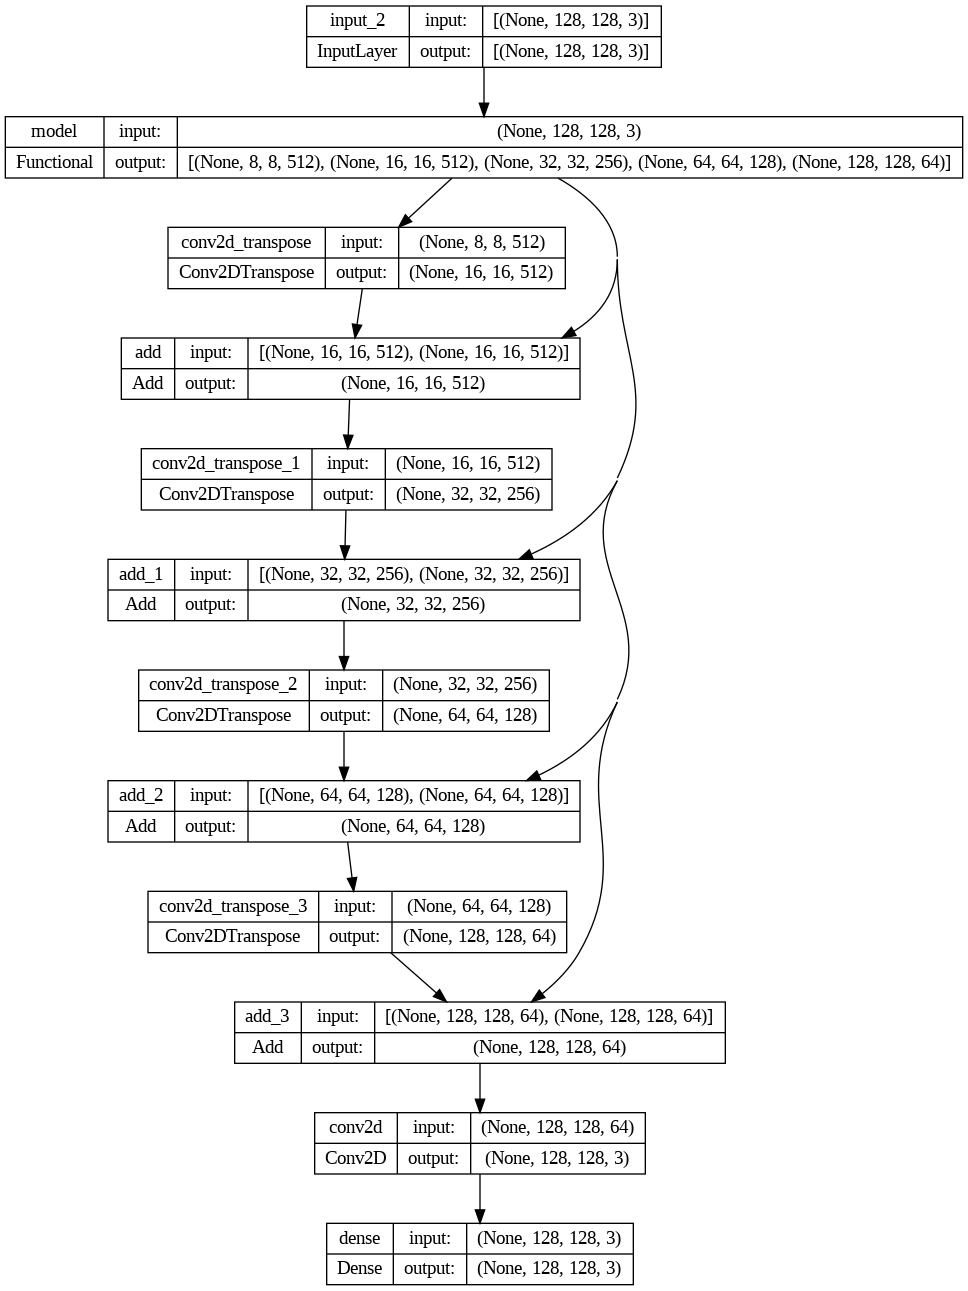

In [14]:
# 모델 구조 시각화
tf.keras.utils.plot_model(unet_model,show_shapes=True)

- 인코더의 중간 출력이 업샘플링 과정에서 디코더의 중간 출력과 합쳐짐
- 각 레이어의 입출력 텐서 크기를 확인

**모델 구조 요약** <br/>
인코더 출력에 사용하기 위해 f_model로부터 유래하는 5개 레이어의 14,714,688개의 파라미터는 학습되지 않도록 고정

In [15]:
# 모델 요약
unet_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 model (Functional)             [(None, 8, 8, 512),  14714688    ['input_2[0][0]']                
                                 (None, 16, 16, 512                                               
                                ),                                                                
                                 (None, 32, 32, 256                                               
                                ),                                                          

**모델 컴파일 및 훈련** <Br/>
- 예측 클래스 개수가 3개인 다중 분류 문제에 맞도록 SparseCategoricalCrossentropy 손실함수를 설정
- Adam 옵티마이저를 적용
- 기본 성능을 확인하는 수준에서 5 epoch만 훈련

In [16]:
# 모델 컴파일 및 훈련
loss_f = tf.losses.SparseCategoricalCrossentropy()
opt = tf.optimizers.Adam(learning_rate)

unet_model.compile(optimizer=opt, loss=loss_f, metrics=['accuracy'])
unet_model.fit(train_ds, batch_size=batch_size, epochs=epoch_num)

Epoch 1/5
230/230 [==============================] - 35s 72ms/step - loss: 1.0374 - accuracy: 0.5370
Epoch 2/5
230/230 [==============================] - 20s 76ms/step - loss: 0.8637 - accuracy: 0.6085
Epoch 3/5
230/230 [==============================] - 21s 74ms/step - loss: 0.8166 - accuracy: 0.6195
Epoch 4/5
230/230 [==============================] - 20s 75ms/step - loss: 0.7778 - accuracy: 0.6233
Epoch 5/5
230/230 [==============================] - 20s 77ms/step - loss: 0.6436 - accuracy: 0.6827


**추론** <Br/>
검증 셋의 배치를 하나 선택하고 predict() 메소드로 이미지 분할 클래스를 예측
- 배치를 구성하는 16개의 이미지 중에서 첫 번째 이미지의 분할 결과를 노트북에 출력
- 정답 마스크 이미지를 출력하고, 앞서 예측한 분할 이미지와 비교
- 어느 정도 객체의 경계를 찾아내는 것을 확인 가능

1/1 [==============================] - 0s 311ms/step


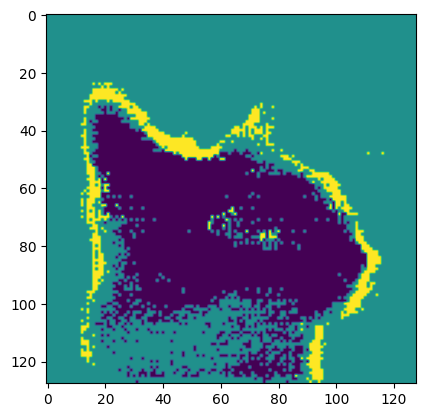

In [19]:
# 1개 배치(16개 이미지)를 선택
img, mask = next(iter(test_ds))

# 모델 예측
pred = unet_model.predict(img)

# 첫번째 이미지 분할 결과를 출력
pred_img=np.argmax(pred[0], -1)
plt.imshow(pred_img)

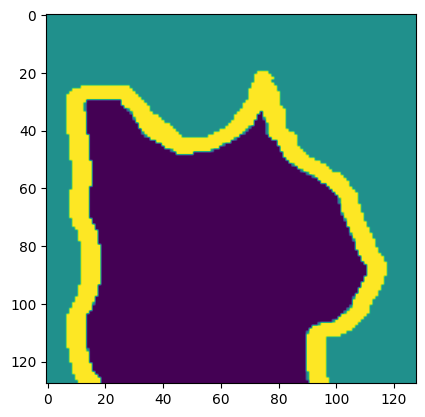

In [20]:
# 첫번째 이미지의 정답 마스크 출력
plt.imshow(np.reshape(mask[0], (128,128)))